In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded!")

Libraries loaded!


In [3]:
CONFIG = {
    'model_name': 'bert-base-uncased',
    'max_length': 128,          # Reduced from 256
    'batch_size': 32,           # Increased for CPU efficiency
    'epochs': 2,                # Reduced epochs
    'learning_rate': 3e-5,      # Slightly higher LR
    'train_samples': 2000,      # Small dataset for speed
    'test_samples': 500,        # Small test set
    'warmup_steps': 50          # Minimal warmup
}

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
from datasets import load_dataset
dataset = load_dataset('imdb')



# Extract balanced subsets (equal positive and negative)
def get_balanced_subset(data, n_samples):
    texts = []
    labels = []

    # Get equal numbers of positive and negative samples
    n_per_class = n_samples // 2
    neg_count = 0
    pos_count = 0

    for item in data:
        if item['label'] == 0 and neg_count < n_per_class:
            texts.append(item['text'])
            labels.append(item['label'])
            neg_count += 1
        elif item['label'] == 1 and pos_count < n_per_class:
            texts.append(item['text'])
            labels.append(item['label'])
            pos_count += 1
        if neg_count >= n_per_class and pos_count >= n_per_class:
            break

    return texts, labels

train_texts, train_labels = get_balanced_subset(dataset['train'], CONFIG['train_samples'])
test_texts, test_labels = get_balanced_subset(dataset['test'], CONFIG['test_samples'])

print(f"Train samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Label distribution - Train: {train_labels.count(0)} neg, {train_labels.count(1)} pos")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train samples: 2000
Test samples: 500
Label distribution - Train: 1000 neg, 1000 pos


In [6]:
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])
print("Tokenizer loaded!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded!


In [11]:
class FastIMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
train_dataset = FastIMDBDataset(train_texts, train_labels, tokenizer, CONFIG['max_length'])
test_dataset = FastIMDBDataset(test_texts, test_labels, tokenizer, CONFIG['max_length'])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Data loaders created! Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Data loaders created! Train batches: 63, Test batches: 16


In [13]:
model = BertForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=2
)
model = model.to(device)

print("Model loaded!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded!


In [14]:
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])

In [15]:
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{correct/total:.3f}'})

    return total_loss / len(train_loader), correct / total

# Step 10: Fast evaluation function
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            batch_predictions = torch.argmax(logits, dim=1)

            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    avg_loss = total_loss / len(test_loader)

    return avg_loss, accuracy, predictions, true_labels


In [16]:
for epoch in range(CONFIG['epochs']):
    print(f'\nEpoch {epoch + 1}/{CONFIG["epochs"]}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer)

    val_loss, val_acc, predictions, true_labels = evaluate(model, test_loader)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')



Epoch 1/2


Evaluating: 100%|██████████| 16/16 [02:33<00:00,  9.57s/it]


Train Loss: 0.5704 | Train Acc: 0.6805
Val Loss: 0.3853 | Val Acc: 0.8540

Epoch 2/2


Evaluating: 100%|██████████| 16/16 [02:38<00:00,  9.90s/it]

Train Loss: 0.3121 | Train Acc: 0.8745
Val Loss: 0.3490 | Val Acc: 0.8560


In [17]:
print(f'Final Test Accuracy: {val_acc:.4f}')


unique_labels = set(true_labels)
print(f"Classes in test set: {unique_labels}")

if len(unique_labels) > 1:
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))
else:
    print("\nWarning: Only one class found in predictions. Cannot generate full classification report.")
    print(f"All predictions are: {'Positive' if list(unique_labels)[0] == 1 else 'Negative'}")


Final Test Accuracy: 0.8560
Classes in test set: {np.int64(0), np.int64(1)}

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.90      0.86       250
    Positive       0.89      0.81      0.85       250

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [19]:
def quick_predict(text):
    model.eval()

    encoding = tokenizer(
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1)

    sentiment = 'Positive' if prediction.item() == 1 else 'Negative'
    confidence = probabilities[0][prediction].item()

    return sentiment, confidence


Evaluating: 100%|██████████| 16/16 [02:38<00:00,  9.92s/it]


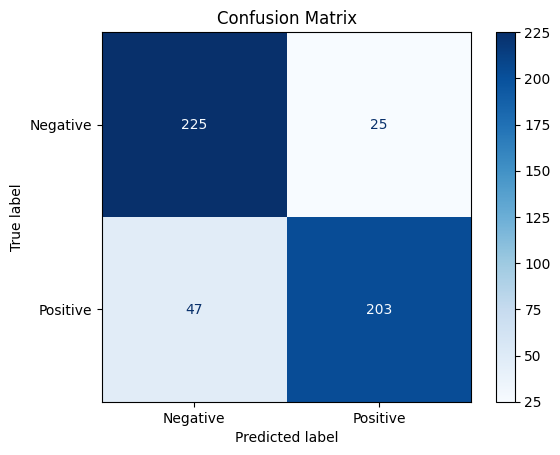

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, _, predictions, true_labels = evaluate(model, test_loader)

cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [20]:
test_reviews = [
    "This movie was amazing! I loved it!",
    "Terrible movie, waste of time.",
    "Great acting and wonderful story.",
    "Boring and poorly made film.",
    "the movie is decent"
]

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = quick_predict(review)
    print(f"{i}. Review: {review}")
    print(f"   Prediction: {sentiment} (Confidence: {confidence:.3f})")
    print()


1. Review: This movie was amazing! I loved it!
   Prediction: Positive (Confidence: 0.978)

2. Review: Terrible movie, waste of time.
   Prediction: Negative (Confidence: 0.960)

3. Review: Great acting and wonderful story.
   Prediction: Positive (Confidence: 0.980)

4. Review: Boring and poorly made film.
   Prediction: Negative (Confidence: 0.957)

5. Review: the movie is decent
   Prediction: Positive (Confidence: 0.705)



In [25]:
def analyze_custom_reviews():
    print("\n" + "="*50)
    print("🎬 MOVIE REVIEW SENTIMENT ANALYZER 🎬")
    print("="*50)
    print("Enter your movie reviews to analyze sentiment!")
    print("Type 'quit' to exit, 'examples' to see sample reviews")
    print("-" * 50)

    while True:
        user_input = input("\n📝 Enter a movie review: ").strip()

        if user_input.lower() == 'quit':
            print("👋 Thanks for using the sentiment analyzer!")
            break

        elif user_input.lower() == 'examples':
            print("\n🎭 Sample reviews to try:")
            examples = [
                "This movie was absolutely incredible! Best film of the year!",
                "Terrible movie, complete waste of time and money.",
                "The acting was phenomenal and the story was captivating.",
                "Boring plot, bad acting, and poor direction.",
                "A masterpiece! Every scene was perfectly crafted."
            ]
            for i, example in enumerate(examples, 1):
                print(f"   {i}. {example}")
            continue

        elif not user_input:
            print("❌ Please enter a review or type 'quit' to exit.")
            continue


        print(f"\n🔍 Analyzing: '{user_input}'")
        print("⏳ Processing...")

        sentiment, confidence = quick_predict(user_input)

        emoji = "😊" if sentiment == "Positive" else "😞"
        confidence_bar = "█" * int(confidence * 10) + "░" * (10 - int(confidence * 10))

        print(f"\n📊 RESULTS:")
        print(f"   Sentiment: {emoji} {sentiment}")
        print(f"   Confidence: {confidence:.1%}")
        print(f"   Confidence Bar: [{confidence_bar}] {confidence:.1%}")

        if confidence > 0.8:
            print(f"   💪 High confidence prediction!")
        elif confidence > 0.6:
            print(f"   👍 Moderate confidence prediction")
        else:
            print(f"   🤔 Low confidence - the review might be neutral")

        print("-" * 50)

analyze_custom_reviews()

print("\n" + "="*40)
print("Training Complete!")
print("="*40)


🎬 MOVIE REVIEW SENTIMENT ANALYZER 🎬
Enter your movie reviews to analyze sentiment!
Type 'quit' to exit, 'examples' to see sample reviews
--------------------------------------------------

📝 Enter a movie review: the movie is excellent 

🔍 Analyzing: 'the movie is excellent'
⏳ Processing...

📊 RESULTS:
   Sentiment: 😊 Positive
   Confidence: 96.3%
   Confidence Bar: [█████████░] 96.3%
   💪 High confidence prediction!
--------------------------------------------------

📝 Enter a movie review: the movie is a flop 

🔍 Analyzing: 'the movie is a flop'
⏳ Processing...

📊 RESULTS:
   Sentiment: 😞 Negative
   Confidence: 81.5%
   Confidence Bar: [████████░░] 81.5%
   💪 High confidence prediction!
--------------------------------------------------

📝 Enter a movie review: quit
👋 Thanks for using the sentiment analyzer!

Training Complete!
